In [122]:

# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [123]:
dataset_train = pd.read_csv('INTC_Dataset/INTC2010-2021.csv')

cols = list(dataset_train)[1:6]
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (2770, 7)
All timestamps == 2770
Featured selected: ['Open', 'High', 'Low', 'Close', 'Adj Close']


In [124]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (2770, 5).


array([[20.790001, 21.030001, 20.73    , 20.879999, 14.86447 ],
       [20.940001, 20.99    , 20.6     , 20.870001, 14.857353],
       [20.809999, 20.93    , 20.67    , 20.799999, 14.807525],
       ...,
       [49.110001, 49.189999, 48.560001, 48.75    , 48.455875],
       [48.75    , 50.189999, 48.720001, 49.82    , 49.519421],
       [49.889999, 51.389999, 49.400002, 49.669998, 49.370323]])

In [125]:

# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-1.12359361],
       [-1.11131971],
       [-1.12195725],
       ...,
       [ 1.19371713],
       [ 1.16425971],
       [ 1.2575412 ]])

In [126]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 5   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (2676, 90, 4).
y_train shape == (2676, 1).


In [127]:

# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from keras.optimizers import Adam

In [128]:

# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(GRU(units=50, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer

model.add(GRU(units=50, return_sequences=True))
model.add(GRU(units=50, return_sequences=True))
model.add(GRU(units=50, return_sequences=False))


# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.001), loss='mean_squared_error')

In [129]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=50, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)


Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 0.3521
Epoch 00001: val_loss improved from inf to 0.11900, saving model to weights.h5
9/9 [==============================] - 4s 464ms/step - loss: 0.3521 - val_loss: 0.1190
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0558
Epoch 00002: val_loss did not improve from 0.11900
9/9 [==============================] - 2s 253ms/step - loss: 0.0558 - val_loss: 0.2175
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0355
Epoch 00003: val_loss improved from 0.11900 to 0.09704, saving model to weights.h5
9/9 [==============================] - 2s 241ms/step - loss: 0.0355 - val_loss: 0.0970
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.0282
Epoch 00004: val_loss did not improve from 0.09704
9/9 [==============================] - 2s 247ms/step - loss: 0.0282 - val_loss: 0.1574
Epoch 5/50
9/9 [==============================] - ETA: 0s - loss: 0.0232
Epoch 00005: val_loss d

Epoch 37/50
9/9 [==============================] - ETA: 0s - loss: 0.0129
Epoch 00037: val_loss did not improve from 0.06231
9/9 [==============================] - 3s 341ms/step - loss: 0.0129 - val_loss: 0.0635
Epoch 38/50
9/9 [==============================] - ETA: 0s - loss: 0.0123
Epoch 00038: val_loss did not improve from 0.06231
9/9 [==============================] - 3s 327ms/step - loss: 0.0123 - val_loss: 0.0641
Epoch 39/50
9/9 [==============================] - ETA: 0s - loss: 0.0129
Epoch 00039: val_loss did not improve from 0.06231
9/9 [==============================] - 3s 323ms/step - loss: 0.0129 - val_loss: 0.0629
Epoch 40/50
9/9 [==============================] - ETA: 0s - loss: 0.0126
Epoch 00040: val_loss did not improve from 0.06231
9/9 [==============================] - 3s 327ms/step - loss: 0.0126 - val_loss: 0.0645
Epoch 41/50
9/9 [==============================] - ETA: 0s - loss: 0.0123
Epoch 00041: val_loss did not improve from 0.06231
9/9 [======================

In [130]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())


In [131]:

# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [132]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Close']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Close']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(100000)

,Close
2010-09-27,19.283417
2010-09-28,19.370626
2010-09-29,19.442068
2010-09-30,19.477747
2010-10-01,19.549141
...,...
2020-12-28,49.224152
2020-12-29,47.747093
2020-12-30,46.882172
2020-12-31,46.684292


In [133]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

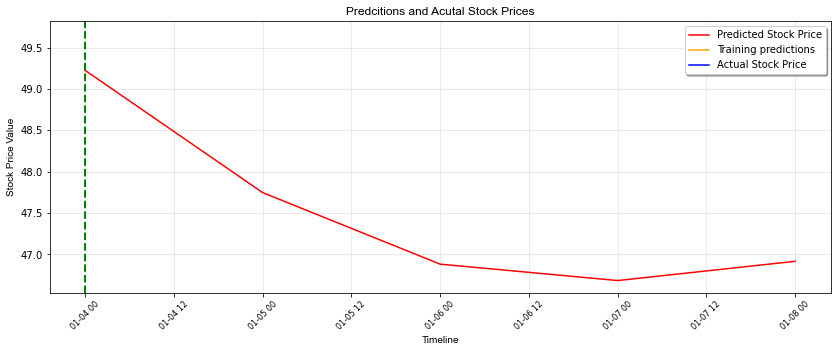

In [136]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING =  '2021-01-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Close'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Close'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Close'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [121]:
import csv


PREDICTIONS_FUTURE.to_csv('Prediction_GRU_AMD_5Year.csv',index=False)